`sdg4varselect` depends on `jax` library but also from `parametrization_cookbook`, this is not mandatory but strongly recommended all the examples will use a specific parametrization.

Let's start by importing all dependencies and the package :

In [5]:
import jax.numpy as jnp
import jax.random as jrd

import parametrization_cookbook.jax as pc

### Mixed Effects Model Specification

First, let's define the model with the abstract object AbstractMixedEffectsModel. We want to define the following logisitc models :

$$ \left\{\begin{array}{rll}
            Y_{i,j} &= m(t_{i,j}; \varphi_i) + \varepsilon_{i,j}
            \\ \varphi_i \sim \mathcal N(\mu, \Gamma)   
            & ; ~\varepsilon_{i,j} \sim \mathcal N(0,\sigma^2).             
        \end{array}\right. ~ \forall i \in\{1,...,N\}, j\in\{1,...,J\}$$

where : $$m(t_{i,j}; \varphi_i) = \frac{\varphi_{1,i}}{1+\exp\left(\frac{\varphi_{2,i}-t_{i,j}}{\tau} \right)}$$


#### Python implementation of the Model

First let define the non-linear function m of our model !

In [6]:
def m(
    params,
    times: jnp.ndarray,  # shape = (J,) [None, :]
    phi1: jnp.ndarray,  # shape = (N,) [:,None]
    phi2: jnp.ndarray,  # shape = (N,) [:,None]
    **kwargs,
) -> jnp.ndarray:  # shape = (N,J)
    """logistic_curve
    phi1 = asymptotic
    phi2 = inflexion
    params.tau = growth rate
    """

    out = phi1[:, None] / (1 + jnp.exp(-(times - phi2[:, None]) / params.tau))
    assert out.shape == times.shape
    return out

We can now define our models as follows. We define a new python class inherited from the `AbstractMixedEffectsModel` class. This implements the minimal structure to define a model from only the function that we have just implemented.

We also want to define a high dimensional covariate model, we inherit from the `AbstractHDModel` class for this.

In [7]:
import functools
from jax import jit

from sdg4varselect.models.abstract.abstract_mixed_effects_model import (
    AbstractMixedEffectsModel,
)


class LogisticMixedEffectsModel(AbstractMixedEffectsModel):
    """define a logistic mixed effects model"""

    def __init__(self, N=1, J=1, **kwargs):
        super().__init__(N=N, J=J, me_name=["phi1", "phi2"], **kwargs)

    def init_parametrization(self):
        # mean_latent,cov_latent and var_residual is a required name
        self._parametrization = pc.NamedTuple(
            mean_latent=pc.RealPositive(shape=(2,), scale=(100, 2000)),
            tau=pc.RealPositive(scale=100),
            cov_latent=pc.MatrixDiagPosDef(dim=2, scale=(100, 2000)),
            var_residual=pc.RealPositive(scale=100),
        )

    @property
    def name(self):
        return f"tutorial_logi_MEM_N{self.N}_J{self.J}_P{self.P}"

    # ============================================================== #
    @functools.partial(jit, static_argnums=0)
    def mixed_effect_function(self, params, *args, **kwargs) -> jnp.ndarray:
        return m(params, *args, **kwargs)

    # ============================================================== #

    def sample(self, params_star, prngkey, **kwargs):
        """Sample one data set for the model"""

        prngkey_time, prngkey_mem = jrd.split(prngkey, num=2)

        # === nlmem_simulation() === #
        time = jnp.linspace(100, 1800, self.J)
        time = jnp.tile(time, (self.N, 1))
        time += 10 * jrd.uniform(prngkey_time, minval=-2, maxval=2, shape=time.shape)

        obs, sim = AbstractMixedEffectsModel.sample(
            self, params_star, prngkey_mem, mem_obs_time=time
        )

        return {"mem_obs_time": time} | obs, sim

### Data Generation
Then we can generate a data set with $N=200$ individuals and $J=15$ observation time per individuals and $P = 10$ covariates

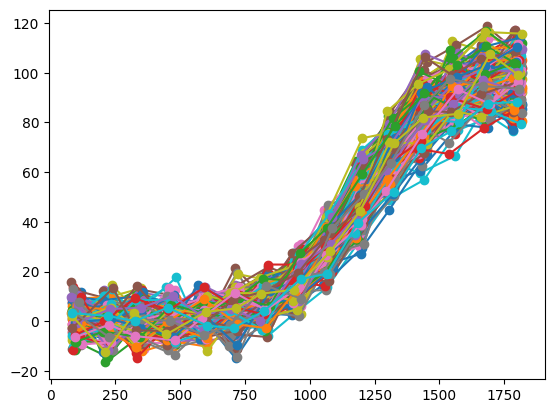

In [8]:
import matplotlib.pyplot as plt

myModel = LogisticMixedEffectsModel(N=200, J=15)

p_star = myModel.new_params(
    mean_latent=jnp.array([100, 1200]),
    cov_latent=jnp.diag(jnp.array([50, 1000])),
    tau=150,
    var_residual=30,
)

myobs, mysim = myModel.sample(p_star, jrd.PRNGKey(0))

ax = plt.figure().add_subplot(1, 1, 1)
_ = ax.plot(myobs["mem_obs_time"].T, myobs["Y"].T, "o-")

# Estimation example

Let's do an estimation of the parameter with the SGD-FIM algorithm

In order to compute the `StochasticProximalGradientDescentFIM` (`SPGD_FIM`) we must define an preconditionner. We use in this example the Fisher Information Matrix with the al ready implemented class `preconditionner.Fisher` !

In [11]:
import sdg4varselect.algo.preconditioner as preconditionner
from sdg4varselect.learning_rate import LearningRate
from copy import copy

step_size = LearningRate(
    coef_heating=0.65,
    preheating=1000,
    heating=3500,
    coef_preheating=float(jnp.log(1e-8)),
)

step_size_approx_sto = copy(step_size)
step_size_approx_sto.heating.step = None

step_size_fisher = copy(step_size_approx_sto)
step_size_fisher.max = 0.9

_ = step_size.plot()
_ = step_size_fisher.plot()
_ = step_size_approx_sto.plot()
# sdgplt.plt.xlim(0, step_size.heating + 1000)

FIM = preconditionner.Fisher(
    step_size_approx_sto=step_size_approx_sto, step_size_fisher=step_size_fisher
)

TypeError: isnan requires ndarray or scalar arguments, got <class 'NoneType'> at position 0.

Now let's define the algorithm and calculate the first estimate !

In [ ]:
from sdg4varselect.algo.sto_grad_descent_precond import (
    StochasticGradientDescentPrecond as SGD_Pred,
)

algo = SGD_Pred(prngkey_estim, 5000, step_size, preconditioner=FIM, lbd=None, alpha=1.0)

# =================== MCMC configuration ==================== #
algo.init_mcmc(theta0, myModel, sd={"phi1": 5, "phi2": 20})


for var_lat in algo.latent_variables.values():
    var_lat.adaptative_sd = True

# ==================== END configuration ==================== #


algo.set_seed(jrd.PRNGKey(0))

prngkey_theta, prngkey_estim = jrd.split(seed)
theta0 = 0.2 * jrd.normal(prngkey_theta, shape=(myModel.parametrization.size,))
# print(myModel.parametrization.reals1d_to_params(theta0))


res = algo.fit(myModel, myobs, theta0, ntry=5, partial_fit=False, save_all=True)

Before plotting the restults, let's cheking the iteration of the MCMC sampler :

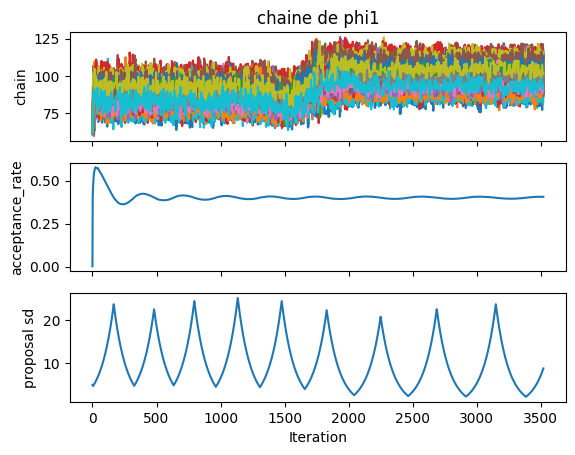

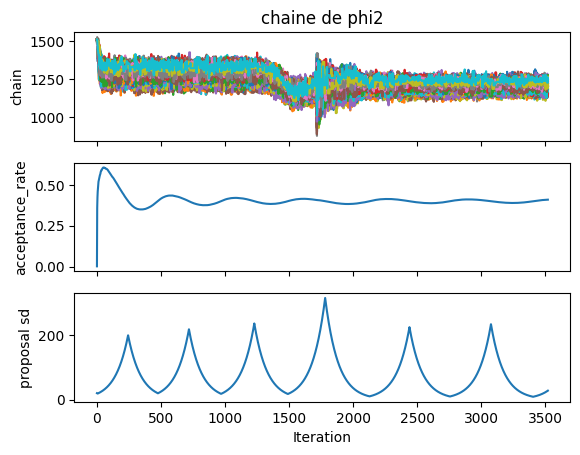

In [9]:
sdgplt.plot_mcmc(algo.latent_variables)

In [8]:
from sdg4varselect.algo import SPGD_FIM


def one_estim(prngkey, model, data, lbd=None, save_all=True):
    prngkey_theta, prngkey_estim = jrd.split(prngkey)
    theta0 = 0.2 * jrd.normal(prngkey_theta, shape=(model.parametrization.size,))
    # print(myModel.parametrization.reals1d_to_params(theta0))

    algo = SPGD_FIM(
        prngkey_estim, 5000, step_size, preconditioner=FIM, lbd=lbd, alpha=1.0
    )
    # =================== MCMC configuration ==================== #
    algo.init_mcmc(theta0, model, sd={"phi1": 5, "phi2": 20})

    for var_lat in algo.latent_variables.values():
        var_lat.adaptative_sd = True
    # ==================== END configuration ==================== #
    res = algo.fit(model, data, theta0, ntry=5, partial_fit=False, save_all=save_all)

    # sdgplt.plot_mcmc(algo.latent_variables)

    return res


multi_estim = MultiRunRes(
    [one_estim(jrd.PRNGKey(i), myModel, myobs, save_all=True) for i in range(2)]
)

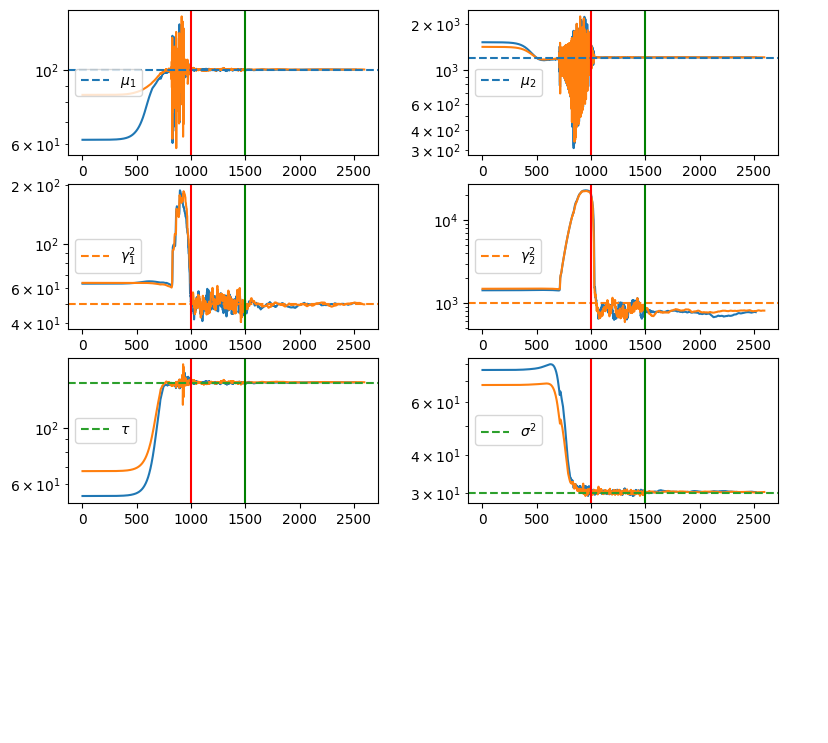

In [10]:
import numpy as np

params_names = np.array(
    [
        "$\\mu_1$",
        "$\\mu_2$",
        "$\\tau$",
        "$\\gamma^2_1$",
        "$\\gamma^2_{12}$",
        "$\\gamma^2_{21}$",
        "$\\gamma^2_2$",
        "$\\sigma^2$",
    ]
    + [f"$\\beta_{i}$" for i in range(myModel.P)]
)

fig = sdgplt.figure(8, 8)
subfigs = fig.subfigures(2, 1, wspace=0.07, height_ratios=[4, 1])
subfigs2 = subfigs[0].subfigures(1, 2, wspace=0.07)

_ = sdgplt.plot_theta(
    multi_estim,
    params_star=myModel.hstack_params(p_star),
    params_names=params_names,
    id_to_plot=[0, 3, 2],  # , 6, 7, 8],
    log_scale=True,
    fig=subfigs2[0],
)
_ = sdgplt.plot_theta(
    multi_estim,
    params_star=myModel.hstack_params(p_star),
    params_names=params_names,
    id_to_plot=[1, 6, 7],
    log_scale=True,
    fig=subfigs2[1],
)
subfigs2[0].axes[0].set_title(None)
for ax in subfigs2[0].axes:
    ax.axvline(step_size.preheating, color="red")
    ax.axvline(step_size.heating, color="green")

subfigs2[1].axes[0].set_title(None)
for ax in subfigs2[1].axes:
    ax.axvline(step_size.preheating, color="red")
    ax.axvline(step_size.heating, color="green")

In [ ]:
from sdg4varselect.outputs import MultiRunRes